# Binary Classification on DVQA

---


* Resources ~ 
  * https://github.com/Cyanogenoid/pytorch-vqa
  * https://github.com/Cyanogenoid/vqa-counting/tree/master/vqa-v2

---

### Table of contents ~
#### 1. Creating the environment
#### 2. Preprocessing the data
#### 3. Training the model
#### 4. Evaluating the model


## Creating the environment
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Upgrade pillow to latest version to resolve an attribute issue when importing model
! pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import os, sys
import warnings
import pandas as pd
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)

#### Creating the train dataset



In [ ]:
json_file_path = "/content/drive/MyDrive/DVQA/qa/train_qa.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

df = pd.DataFrame(contents)
df.head()

,question,question_id,template_id,answer,image,answer_bbox
0,Which bar has the largest value?,1101,reasoning,soil,bar_train_00000001.png,"[348.32196969696963, 404.2, 47.875, 37.0]"
1,Which bar has the smallest value?,1102,reasoning,essay,bar_train_00000001.png,"[85.34469696969697, 404.2, 68.625, 37.0]"
2,What is the value of the largest bar?,1103,reasoning,2,bar_train_00000001.png,[]
3,What is the value of the smallest bar?,1104,reasoning,1,bar_train_00000001.png,[]
4,What is the difference between the largest and...,1105,reasoning,1,bar_train_00000001.png,[]


#### Creating the validation dataset

In [ ]:
json_file_path = '/content/drive/MyDrive/DVQA/qa/val_hard_qa.json'

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dfv = pd.DataFrame(contents)
dfv.head()

,question,question_id,template_id,answer,image,answer_bbox
0,How many algorithms have accuracy lower than 9...,3101,reasoning,two,bar_val_hard_00000001.png,[]
1,Which algorithm has highest accuracy for any d...,3102,reasoning,brave,bar_val_hard_00000001.png,"[302.5178277191559, 394.48, 82.5, 40.0]"
2,Which algorithm has lowest accuracy for any da...,3103,reasoning,brave,bar_val_hard_00000001.png,"[302.5178277191559, 394.48, 82.5, 40.0]"
3,What is the highest accuracy reported in the w...,3104,reasoning,9,bar_val_hard_00000001.png,[]
4,What is the lowest accuracy reported in the wh...,3105,reasoning,4,bar_val_hard_00000001.png,[]


#### Creating the test dataset

In [ ]:
json_file_path = '/content/drive/MyDrive/DVQA/qa/val_easy_qa.json'

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dt = pd.DataFrame(contents)
dt.head()

,question,question_id,template_id,answer,image,answer_bbox
0,How many algorithms have accuracy lower than 7...,2101,reasoning,five,bar_val_easy_00000001.png,[]
1,Which algorithm has highest accuracy for any d...,2102,reasoning,heat,bar_val_easy_00000001.png,"[371.8024891774892, 368.325, 37.0, 56.25]"
2,What is the highest accuracy reported in the w...,2103,reasoning,9,bar_val_easy_00000001.png,[]
3,Which algorithm has the smallest accuracy summ...,2104,reasoning,twelve,bar_val_easy_00000001.png,"[299.6304112554112, 368.325, 37.0, 72.875]"
4,Which algorithm has the largest accuracy summe...,2105,reasoning,frame,bar_val_easy_00000001.png,"[227.45833333333331, 368.325, 37.0, 67.625]"


## Preproccesing the data
---

#### Downloading the prebuilt model

In [ ]:
if not os.path.isfile('./pytorch-vqa/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-vqa.git
sys.path.append(os.path.realpath('./pytorch-vqa'))

#### Accelerating using CUDA

In [ ]:
try: 
    import torch
except:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
    !pip install -q \
      http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl \
      torchvision

In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#### Preprocessing the questions

In [ ]:
!python /content/pytorch-vqa/preprocess-vocab.py

> The following edits were made ~
* In the file config.py, 'qa_path' was changed
* Lines 47 to 56 in utils.py were edited for the new file paths
* In line 176, in data.py, 'questions = [q['question'] for q in questions_json['questions']]' was changed to 'questions = [q['question'] for q in questions_json]'
* In line 184, in data.py, 'answers = [[a['answer'] for a in ans_dict['answers']] for ans_dict in answers_json['annotations']]' was changed to 'answers = [a['answer'] for a in answers_json]'


In [ ]:
# Opening JSON file
with open('/content/vocab.json', 'r') as file:
  
    # Reading from json file
    json_object = json.load(file)
vocab = json_object
print(vocab)
print(len(vocab))

{'question': {'the': 1, 'of': 2, 'is': 3, 'in': 4, 'what': 5, 'bar': 6, 'value': 7, 'bars': 8, 'how': 9, 'many': 10, 'which': 11, 'than': 12, 'chart': 13, 'group': 14, 'are': 15, 'accuracy': 16, 'label': 17, 'from': 18, 'object': 19, 'algorithm': 20, 'least': 21, 'people': 22, 'sold': 23, 'preferred': 24, 'units': 25, 'has': 26, 'item': 27, 'left': 28, 'each': 29, 'whole': 30, 'values': 31, 'color': 32, 'a': 33, 'summed': 34, 'all': 35, 'smallest': 36, 'largest': 37, 'does': 38, 'most': 39, 'dataset': 40, 'across': 41, 'category': 42, 'percentage': 43, 'horizontal': 44, 'individual': 45, 'by': 46, 'one': 47, 'at': 48, 'scale': 49, 'represent': 50, 'presented': 51, 'smaller': 52, 'contain': 53, 'second': 54, 'bottom': 55, 'first': 56, 'any': 57, 'were': 58, 'prefer': 59, 'store': 60, 'element': 61, 'larger': 62, 'more': 63, 'without': 64, 'solid': 65, 'single': 66, 'patterns': 67, 'with': 68, 'have': 69, 'number': 70, 'sum': 71, 'and': 72, 'less': 73, 'valued': 74, 'contains': 75, 'grou

In [ ]:
vocab.keys()  # dict_keys(['question', 'answer'])
list(vocab['question'].items())

[('the', 1),
 ('of', 2),
 ('is', 3),
 ('in', 4),
 ('what', 5),
 ('bar', 6),
 ('value', 7),
 ('bars', 8),
 ('how', 9),
 ('many', 10),
 ('which', 11),
 ('than', 12),
 ('chart', 13),
 ('group', 14),
 ('are', 15),
 ('accuracy', 16),
 ('label', 17),
 ('from', 18),
 ('object', 19),
 ('algorithm', 20),
 ('least', 21),
 ('people', 22),
 ('sold', 23),
 ('preferred', 24),
 ('units', 25),
 ('has', 26),
 ('item', 27),
 ('left', 28),
 ('each', 29),
 ('whole', 30),
 ('values', 31),
 ('color', 32),
 ('a', 33),
 ('summed', 34),
 ('all', 35),
 ('smallest', 36),
 ('largest', 37),
 ('does', 38),
 ('most', 39),
 ('dataset', 40),
 ('across', 41),
 ('category', 42),
 ('percentage', 43),
 ('horizontal', 44),
 ('individual', 45),
 ('by', 46),
 ('one', 47),
 ('at', 48),
 ('scale', 49),
 ('represent', 50),
 ('presented', 51),
 ('smaller', 52),
 ('contain', 53),
 ('second', 54),
 ('bottom', 55),
 ('first', 56),
 ('any', 57),
 ('were', 58),
 ('prefer', 59),
 ('store', 60),
 ('element', 61),
 ('larger', 62),
 ('mo

#### Creating OCR labels

#### For train set

In [ ]:
def OCR(row):
    if len(row["answer_bbox"]) < 1:
        return 0
    else:
        return 1
dft = df.assign(ocr=df.apply(OCR, axis=1))
dft.head()

,question,question_id,template_id,answer,image,answer_bbox,ocr
0,Which bar has the largest value?,1101,reasoning,soil,bar_train_00000001.png,"[348.32196969696963, 404.2, 47.875, 37.0]",1
1,Which bar has the smallest value?,1102,reasoning,essay,bar_train_00000001.png,"[85.34469696969697, 404.2, 68.625, 37.0]",1
2,What is the value of the largest bar?,1103,reasoning,2,bar_train_00000001.png,[],0
3,What is the value of the smallest bar?,1104,reasoning,1,bar_train_00000001.png,[],0
4,What is the difference between the largest and...,1105,reasoning,1,bar_train_00000001.png,[],0


#### For validation set

In [ ]:
def OCR(row):
    if len(row["answer_bbox"]) < 1:
        return 0
    else:
        return 1
dv = dfv.assign(ocr=dfv.apply(OCR, axis=1))
dv.head()

,question,question_id,template_id,answer,image,answer_bbox,ocr
0,How many algorithms have accuracy lower than 9...,3101,reasoning,two,bar_val_hard_00000001.png,[],0
1,Which algorithm has highest accuracy for any d...,3102,reasoning,brave,bar_val_hard_00000001.png,"[302.5178277191559, 394.48, 82.5, 40.0]",1
2,Which algorithm has lowest accuracy for any da...,3103,reasoning,brave,bar_val_hard_00000001.png,"[302.5178277191559, 394.48, 82.5, 40.0]",1
3,What is the highest accuracy reported in the w...,3104,reasoning,9,bar_val_hard_00000001.png,[],0
4,What is the lowest accuracy reported in the wh...,3105,reasoning,4,bar_val_hard_00000001.png,[],0


#### For test set

In [ ]:
def OCR(row):
    if len(row["answer_bbox"]) < 1:
        return 0
    else:
        return 1
dt = dt.assign(ocr=dt.apply(OCR, axis=1))
dt.head()

,question,question_id,template_id,answer,image,answer_bbox,ocr
0,How many algorithms have accuracy lower than 7...,2101,reasoning,five,bar_val_easy_00000001.png,[],0
1,Which algorithm has highest accuracy for any d...,2102,reasoning,heat,bar_val_easy_00000001.png,"[371.8024891774892, 368.325, 37.0, 56.25]",1
2,What is the highest accuracy reported in the w...,2103,reasoning,9,bar_val_easy_00000001.png,[],0
3,Which algorithm has the smallest accuracy summ...,2104,reasoning,twelve,bar_val_easy_00000001.png,"[299.6304112554112, 368.325, 37.0, 72.875]",1
4,Which algorithm has the largest accuracy summe...,2105,reasoning,frame,bar_val_easy_00000001.png,"[227.45833333333331, 368.325, 37.0, 67.625]",1


#### Encoding the questions

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
features_train = dft['question']
labels_train = dft['ocr']
features_val = dv['question']
labels_val = dv['ocr']
features_test = dt['question']
labels_test = dt['ocr']

In [ ]:
mlb = MultiLabelBinarizer()
one_hot_encoded_train = mlb.fit_transform(features_train)
one_hot_encoded_val = mlb.fit_transform(features_val)
one_hot_encoded_test = mlb.fit_transform(features_test)

## Training the model
---

In [ ]:
X_train = one_hot_encoded_train
y_train = np.array(labels_train)
X_val = one_hot_encoded_val
y_val = np.array(labels_val)
X_test = one_hot_encoded_test
y_test = np.array(labels_test)

#### Building the model

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

In [ ]:
model = Sequential()
model.add(Embedding(3000,40,input_length=44))
model.add(Dropout(0.5))
model.add(LSTM(22, activation = 'sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 44, 40)            120000    
                                                                 
 dropout (Dropout)           (None, 44, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 22)                5544      
                                                                 
 dropout_1 (Dropout)         (None, 22)                0         
                                                                 
 dense (Dense)               (None, 1)                 23        
                                                                 
Total params: 125,567
Trainable params: 125,567
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=128,epochs=5)

Epoch 1/5
18167/18167 [==============================] - 1708s 94ms/step - loss: 0.5748 - accuracy: 0.6811 - val_loss: 0.4967 - val_accuracy: 0.7272
Epoch 2/5
18167/18167 [==============================] - 1714s 94ms/step - loss: 0.5245 - accuracy: 0.7121 - val_loss: 0.4658 - val_accuracy: 0.7793
Epoch 3/5
18167/18167 [==============================] - 1703s 94ms/step - loss: 0.4889 - accuracy: 0.7509 - val_loss: 0.3994 - val_accuracy: 0.8291
Epoch 4/5
18167/18167 [==============================] - 1703s 94ms/step - loss: 0.5002 - accuracy: 0.7550 - val_loss: 0.3834 - val_accuracy: 0.8565
Epoch 5/5
18167/18167 [==============================] - 1699s 93ms/step - loss: 0.4365 - accuracy: 0.7891 - val_loss: 0.3761 - val_accuracy: 0.8598


In [ ]:
model.save_weights('binary_classifier.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/DVQA/Binary Classifier/binary_classifier.h5')

## Evaluating the model
---

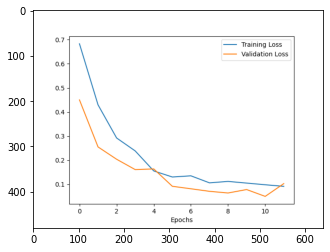

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/DVQA/Binary Classifier/Performance Measure.png').convert('RGB')
plt.imshow(img)

In [ ]:
import numpy as np
pred = model.predict(X_test)

In [ ]:
pred = (pred > 0.5).astype("int32")

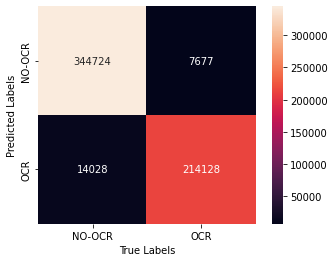

In [ ]:
# Plotting the confusion matrix

import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", xticklabels = ['NO-OCR', 'OCR'], yticklabels = ['NO-OCR', 'OCR'])
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.show()

In [ ]:
# Measuring Accuracy

from sklearn import metrics

'''
  0 : 'NO-OCR'
  1 : 'OCR'
'''

print(metrics.classification_report(y_test, pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    358752
           1       0.94      0.97      0.95    221805

    accuracy                           0.96    580557
   macro avg       0.96      0.96      0.96    580557
weighted avg       0.96      0.96      0.96    580557

